In [1]:
#import all da nice stuff
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil

In [2]:
base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'

LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"

LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right= 5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [306]:
Nt_codon_pref_dict = {0:{},
                     1:{},
                     2:{}}
for pos in range(3):
    for Nt in ["A", "C", "G","T"]:
        Nt_codon_pref_dict[pos][Nt] = sum([codon[pos] == Nt for codon in ecoli_pref.values()])


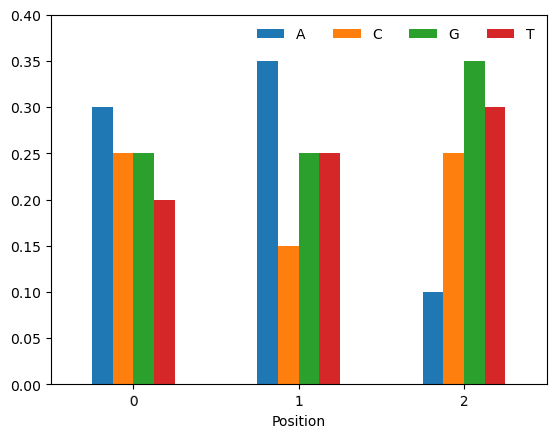

In [316]:
# grouped barplot from dict 
df = pd.DataFrame(Nt_codon_pref_dict)
df = df/df.sum(0)


df.transpose().plot.bar()
plt.legend(ncol = 4, frameon = False)
plt.ylim(0,0.4)
plt.xlabel("Position")
plt.xticks(rotation = 2)
plt.show()

# Functions

In [115]:
def find(string, value_list):
    indexes = [string.find(letter) for letter in value_list]
    try: 
        ind = min([index for index in indexes if index != -1])
    except:
        ind = 400 #250
    return ind

def read_sequences(variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False):
    """
    read sequences from fastq files while filtering for quality score (read is aborted at first nt with higher error rate than 1%)
    arbitrary_cutoff_a: at which position to arbitrary cut off the forward reads that already went through the quality score filter (= max length of the reads)
    arbitrary_cutoff_b: at which position to arbitrary cut off the backward reads that already went through the quality score filter (= max length of the reads)
    returns list of sequences
    """
    a_sequences = []
    b_sequences = []
    quality_score = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']

    with open(f'{base_dir}/data/fastq/{variant}_R1_001.fastq', "rt") as a_file, open(f'{base_dir}/data/fastq/{variant}_R2_001.fastq', "rt") as b_file:

        a_reader = QualityIO.FastqGeneralIterator(a_file)
        b_reader = QualityIO.FastqGeneralIterator(b_file)
        
        for total_read, (a, b) in enumerate(zip(a_reader, b_reader)):
                a_id, a_seq, a_qual = a
                b_id, b_seq, b_qual = b
                cutoff_a = find(a_qual, quality_score)
                cutoff_b = find(b_qual, quality_score)

                if arbitrary_cutoff_a and catch_left in a_seq: # cut off a_seq to an (arbitrary) chosen maximum length (=arbitrary_cutoff_a)
                    if cutoff_a > (a_seq.index(catch_left) + arbitrary_cutoff_a):
                        cutoff_a = a_seq.index(catch_left)  + len(catch_left) + arbitrary_cutoff_a 
                
                if arbitrary_cutoff_b and dna_rev_comp(catch_right) in b_seq: 
                    if cutoff_b > (b_seq.index(dna_rev_comp(catch_right)) + arbitrary_cutoff_b):
                        cutoff_b =b_seq.index(dna_rev_comp(catch_right))+ len(catch_right) + arbitrary_cutoff_b
                    
                a_sequences.append(a_seq[:cutoff_a])
                b_sequences.append(b_seq[:cutoff_b])
        print("total reads", total_read+1)

    return a_sequences, b_sequences

def gather_AA_variants(a_seq, b_seq,use_backward_read=True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
    """
    returns a dictionary with the counts of each amino acid at each position
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    
    for idx in range(len(LOV)):
        mutation_dict[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
                            'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
                            'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
                            'W':0, 'Y':0, '*':0, 'wt':0}
        
    for a_seq, b_seq in zip(a_seq, b_seq):
        if use_forward_read:
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                tr_a = translate_dna2aa(gene_a)
                total_muts_a = sum([LOV_gene[idx] != gene_a[idx] for idx in range(len(gene_a))])
                if total_muts_a <= 5: 
                    for idx, pos in enumerate(tr_a):
                        mutation_dict[idx][pos] += 1
        if use_backward_read: 
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                tr_b = translate_dna2aa(gene_b)
                tr_b = tr_b[::-1]
                for idx, pos in enumerate(tr_b):
                    mutation_dict[len(LOV)-idx-1][pos] += 1

    return mutation_dict

def gather_codon_variants(a_seq, b_seq , use_backward_read= True,use_forward_read = True, catch_left = catch_left, catch_right = catch_right, codons = codons):
    """
    returns a dictionary with the counts of each codon at each position
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    
    for idx in range(0, gene_len//3):
        mutation_dict[idx] = {codon: 0 for codon in codons}

    for a_seq, b_seq in zip(a_seq, b_seq):
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                 #tr_a = translate_dna2aa(gene_a)
                total_muts_a = sum([LOV_gene[idx] != gene_a[idx] for idx in range(len(gene_a))])
                if total_muts_a <= 5: 
                    for idx in range(len(gene_a)//3): # triplets
                        mutation_dict[idx][gene_a[idx*3:idx*3+3]] += 1
        if use_backward_read:
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                #tr_b = translate_dna2aa(gene_b)
                gene_b = gene_b[::-1] 
                for idx in range(len(gene_b)//3): # triplets 
                    mutation_dict[-idx-1][gene_b[-idx*3-1:-idx*3-4]] += 1 # start from the end and update the mutation_dict for each triplet

    return mutation_dict



def gather_nt_variants(a_seq, b_seq , use_backward_read= True,use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
    """
    returns a dictionary with the counts of each nt at each position
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    
    for idx in range(gene_len):
        mutation_dict[idx] = {'A':0, 'T':0, 'G':0, 'C':0}

    for a_seq, b_seq in zip(a_seq, b_seq):
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                #tr_a = translate_dna2aa(gene_a)
                total_muts_a = sum([LOV_gene[idx] != gene_a[idx] for idx in range(len(gene_a))])
                if total_muts_a <= 5: 
                    for idx, pos in enumerate(gene_a):
                        mutation_dict[idx][pos] += 1
        if use_backward_read:
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                #tr_b = translate_dna2aa(gene_b)
                gene_b = gene_b[::-1]
                for idx, pos in enumerate(gene_b):
                    mutation_dict[-idx-1][pos] += 1

    return mutation_dict


def process_reads(AA_sequence,use_backward_read = True, use_forward_read = True, arbitrary_cutoff_a = False, arbitrary_cutoff_b= False, variants = None):
    """
    process reads for given variants
    use_backward_read: whether or not to use the backward read
    arbitrary_cutoff: where to cut off the forward sequence (maximum length of the reads, otherwise the cutoff is determined by the quality score = 1% error rate)
    if variants = None, all variants stored in the fastq folder are processed
    """
    variants_dict = {}
    path = f'{base_dir}/data/fastq'
    filenames = glob.glob(f'{path}/*')

    if variants is not None: # filter filenames for given variants
        filenames = [path for path in filenames if any(variant in path for variant in variants)]

    for name in filenames: 
        if '_R1' in name:
            name = name.split('/')[-1].split('_R')[0]
            f1 = name
            a_seq, b_seq = read_sequences(f1, arbitrary_cutoff_a = arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b)
            variants_dict[name] = {}
            variants_dict[name] = get_variants(a_seq,b_seq,use_backward_read=use_backward_read,use_forward_read=use_forward_read)

            print(f'Done: {name}')

        # with open(f'{path}/{variant}_variants.pickle', 'wb') as handle:
        #     pkl.dump(variants_dict, handle)
    return variants_dict

def get_variants(a_seq,b_seq,use_backward_read=True,use_forward_read=True):
    
    variants_dict = {}
    variants_dict["AA"] = gather_AA_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
    variants_dict["DNA"] = gather_nt_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
    variants_dict["Codons"] = gather_codon_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)

    return variants_dict


In [386]:
## evaluation 

### calculate sum of single, double and triple mutants
def gather_n_mutations(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True, use_triplets = False):
    """
    returns a dictionary with the number of single, double, triple (...) mutants
    a_seq, b_seq = list of sequences
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if use_forward_read and catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            if use_triplets: 
                 n_muts_a_seq = sum([reference_seq[i:i+3] != gene_a[i:i+3] for i in range(0,len(gene_a)//3*3,3)])
            else: 
                n_muts_a_seq = sum([reference_seq[i] != gene_a[i] for i in range(len(gene_a))])

        else: n_muts_a_seq = 0
            
        if use_backward_read and dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                n_muts_b_seq = sum([reference_seq[::-1][i] != gene_b[i] for i in range(len(gene_b))])
                
        else: n_muts_b_seq = 0

        n_muts = n_muts_a_seq + n_muts_b_seq
        
        if n_muts in mutation_dict:
            mutation_dict[n_muts] += 1
        else:
            mutation_dict[n_muts] = 1

    return mutation_dict


### calculate the mutagenic spectrum
def mut_spectrum(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right, treshold = 5):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference nt: {mutated nt: count/percentage}}
    """
    ## reference nt : {mutated nt: count}
    mut_spec = {'A': {'A':0, 'C':0, 'G':0, 'T':0},
                'C': {'A':0, 'C':0, 'G':0, 'T':0},
                'G': {'A':0, 'C':0, 'G':0, 'T':0},
                'T': {'A':0, 'C':0, 'G':0, 'T':0}}
    
    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
                ## if number of total muts exceeds 5, we consider this sequence to have an indel or sequencing error (leading to a frameshift) and exclude it from the analysis (since we only want to consider mutations)
                total_muts_a = sum([reference_seq[idx] != gene_a[idx] for idx in range(len(gene_a))])
                if total_muts_a <= treshold: 
                    for idx, nt in enumerate(gene_a): 
                        if reference_seq[idx] != nt:
                            mut_spec[reference_seq[idx]][nt] += 1
                
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                total_muts_b = sum([reference_seq[::-1][idx] != gene_b[idx] for idx in range(len(gene_b))])
                ## if number of total muts exceeds 5, we consider this sequence to have an indel or sequencing error (leading to a frameshift) and exclude it from the analysis (since we only want to consider mutations)
                if total_muts_b <= 5: 
                    for idx, nt in enumerate(gene_b):
                        if reference_seq[::-1][idx] != nt:
                            mut_spec[reference_seq[::-1][idx]][nt] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc

### calculate the mutagenic spectrum codon-wise
def mut_spectrum_codons(a_seq, b_seq, reference_seq, use_backward_read = False, use_forward_read = True, codon_list = codons, catch_left = catch_left, catch_right = catch_right, treshold = 10):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum of codons and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference codon: {mutated codon: count/percentage}}
    """
    ## reference codon : {mutated codon: count}
    mut_spec = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list}

    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
                ## if number of total muts exceeds 5, we consider this sequence to have an indel or sequencing error (leading to a frameshift) and exclude it from the analysis (since we only want to consider mutations)
                total_muts_a = sum([reference_seq[idx] != gene_a[idx] for idx in range(len(gene_a))])
                if total_muts_a <= treshold: 
                    for idx in range(0,len(gene_a)//3*3,3): 
                        if reference_seq[idx:idx+3] != gene_a[idx:idx+3]:
                            mut_spec[reference_seq[idx:idx+3]][gene_a[idx:idx+3]] += 1
                
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                total_muts_b = sum([reference_seq[::-1][idx] != gene_b[idx] for idx in range(len(gene_b))])
                ## if number of total muts exceeds 5, we consider this sequence to have an indel or sequencing error (leading to a frameshift) and exclude it from the analysis (since we only want to consider mutations)
                if total_muts_b <= treshold: 
                    for idx in range(0,len(gene_b)//3*3,3):
                        if reference_seq[::-1][idx:idx+3] != gene_b[idx:idx+3]:
                            mut_spec[reference_seq[::-1][idx:idx+3]][gene_b[idx:idx+3]] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc


def plot_mutation_spectrum(data, samplename , fig_folder = None, colormap = "viridis"):
    """
    plot mutation spectrum (%) as heatmap
    data = dataframe with the mutagenic spectrum (rows = reference nt, columns = mutated nt)
    savepath = folder path to save the figure
    """
    f, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(data, annot=True, linewidths=.5, ax=ax, vmin = 0, cbar = False, square = True, linecolor = "black", cmap = colormap)
    plt.xlabel('Mutated base (%)', fontsize = 10)
    plt.ylabel('Reference base (%)', fontsize = 10)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(.5)
    #ax.set_facecolor('gray')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    plt.title(f"{samplename} mutagenic spectrum", fontsize = 12)
    if fig_folder is not None:
        plt.savefig(f"{fig_folder}/{samplename}_mutagenic_spectrum_perc.pdf")
    plt.show()


def plot_mutation_enrichment(data, name, ref_seq, backward = False, data_type = "DNA", fig_folder = None):
    """
    data_type = "DNA", "AA" or "Codon" 
    reference nucleotides/AAs/Codons are shown in grey (set to NA)
    backward: if True, only backward reads are used
    input data should be a dataframe with the relative counts of each nucleotide/AA/Codon at each position
    name = plot title
    """
    #process data
    if data_type == "DNA":
        Nt_order = ['A','C', 'G', 'T']
        data = data.loc[Nt_order]
    elif data_type == "AA": 
        AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
        data = data.loc[AA_order]
    

    #mask = data.isnull()
    # set max value = original Nt (AA) of each column to NA (as "true" nt)
    #data = data.mask(data == data.max())
    
    ## mask at each position the nucleotide of the reference sequence
    read_len = data.shape[1]
    
    if data_type in ["DNA", "AA"]:
        if backward: 
            ref_seq = ref_seq[::-1]
            for idx in range(read_len):
                data.loc[ref_seq[idx], len(ref_seq)-idx-1] = np.nan
        else: 
            for idx in range(read_len):
                data.loc[ref_seq[idx], idx] = np.nan

    elif data_type == "Codons":
        if backward: 
            ref_seq = ref_seq[::-1]
            for idx in range(0,read_len//3*3,3):
                data.loc[ref_seq[idx:idx+3], len(ref_seq//3)-idx-1] = np.nan
        else: 
            for idx in range(read_len):
                data.loc[ref_seq[idx*3:idx*3+3], idx] = np.nan
        

    #center colorbar
    #vcenter = 0
    #vmin, vmax = data.min().min(), data.max().max()
    #normalize = mcolors.TwoSlopeNorm(vcenter=0.02, vmin=0, vmax=0.04)

    plt.figure(figsize=(30,10))
    sns.reset_defaults()
    
    #sns.set(font_scale =5)
    ax = sns.heatmap(data=data, cmap='viridis', cbar_kws={'label': f"relative counts"}, yticklabels=True)#, mask=mask)
    plt.title(name, fontsize=20)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.xaxis.set_tick_params(width=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    ax.yaxis.set_tick_params(width=2)
    ax.set_facecolor('gray')
    ax.grid(False)
    if fig_folder is not None:    
        plt.savefig(f"{fig_folder}/{name}_mutation_enrichement.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

def mutation_rate_vs_read_depth(a_seq, b_seq, percs , name, n_perms = 30, fig_folder = None, use_backward_read = False):
    total_reads = len(a_seq)
    coverages_dict = {}
    mut_rates_AA_dict = {}
    mut_rates_DNA_dict = {}

    for perc in percs:  
        perc= round(perc,2) 
        coverages = []
        mut_rate_AAs = []
        mut_rate_DNAs = []

        for n_perm in range(n_perms): 
            a_seq_frac = np.random.choice(a_seq, round(perc * total_reads), replace=False)
            b_seq_frac = np.random.choice(b_seq, round(perc * total_reads), replace=False)
            frac_variants = get_variants(a_seq_frac, b_seq = b_seq_frac, use_backward_read = use_backward_read, use_forward_read = True)
            frac_variants["DNA"] = pd.DataFrame.from_dict(frac_variants["DNA"])
            frac_variants["DNA"] = frac_variants["DNA"].loc[:,frac_variants["DNA"].sum() > 0]
            frac_variants["AA"] = pd.DataFrame.from_dict(frac_variants["AA"])
            frac_variants["AA"] = frac_variants["AA"].loc[:,frac_variants["AA"].sum() > 0]
            
            coverage = frac_variants['DNA'].sum().sum()/(frac_variants['DNA'].max().max()*frac_variants['DNA'].shape[1])*100

            mut_rate_AA = frac_variants['AA'].max()/frac_variants['AA'].sum()-1
            mut_rate_AA = abs(mut_rate_AA.sum())

            mut_rate_DNA = frac_variants['DNA'].max()/frac_variants['DNA'].sum()-1
            mut_rate_DNA = abs(mut_rate_DNA.sum()) #round(mut_rate/coverage*100,2)

            coverages.append(coverage)
            print(coverage)
            mut_rate_AAs.append(mut_rate_AA)#round(mut_rate_AA/coverage*100,2))
            mut_rate_DNAs.append(mut_rate_DNA)#round(mut_rate_DNA/coverage*100,2))

        coverages_dict[perc] = coverages
        mut_rates_AA_dict[perc] = mut_rate_AAs
        mut_rates_DNA_dict[perc] = mut_rate_DNAs

    ## plot
    plt.figure(figsize=(10,5))
    sns.stripplot(data=mut_rates_DNA_dict,  alpha=0.5, color="tab:blue")
    sns.stripplot(data=mut_rates_AA_dict,  alpha=0.5, color="tab:orange")
    plt.ylim(0)

    blue_patch = Line2D([0], [0], label='DNA', marker='o', markersize=5,linestyle='', color = "tab:blue", alpha = 0.7)
    orange_patch = Line2D([0], [0], label='AA', marker='o', markersize=5, linestyle='', color = "tab:orange", alpha = 0.7)
    plt.legend(handles =[orange_patch, blue_patch],  loc = "upper right", frameon = False)
    plt.xlabel("Read depth (proportion of total reads)")
    plt.ylabel("Mutation rate (# mutations per sequence)")
    plt.title(name)
    if fig_folder: 
        plt.savefig(f"{fig_folder}/{name}_mutation_rate_vs_read_depth.pdf")
    plt.show()

    return coverages_dict, mut_rates_AA_dict, mut_rates_DNA_dict

            
def calc_mut_spectrum_vs_read_depth(a_seq,b_seq, reference_seq, use_backward_read = False, use_forward_read= True, prop = 0.5, n_perms = 30): 
    mut_spec_diff_sum = pd.DataFrame(0, index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"]) 
    mean_diffs = []

    ## calculate "reference" mutagenic spectrum
    _, mut_spec_perc_ref = mut_spectrum(a_seq=a_seq, b_seq=b_seq, reference_seq=reference_seq, use_backward_read = use_backward_read, use_forward_read = use_forward_read)
    mut_spec_perc_ref = pd.DataFrame.from_dict(mut_spec_perc_ref)

    for n_perm in range(n_perms):
    
        a_seq_frac = np.random.choice(a_seq, round(prop * len(a_seq)), replace=False)
        b_seq_frac = np.random.choice(b_seq, round(prop * len(b_seq)), replace=False)
        _, mut_spec_perc_frac = mut_spectrum(a_seq = a_seq_frac, b_seq = b_seq_frac, reference_seq=reference_seq, use_backward_read = use_backward_read, use_forward_read = use_forward_read)
        mut_spec_perc_frac = pd.DataFrame.from_dict(mut_spec_perc_frac)

        # calculate difference between the two mutagenic spectra
        mut_spec_diff = (mut_spec_perc_frac - mut_spec_perc_ref)**2
        mean_diff = mut_spec_diff.mean().mean()
        mean_diffs.append(mean_diff)

        # calculate the sum of the squared differences over all permutations
        mut_spec_diff_sum = mut_spec_diff_sum + mut_spec_diff

    # calculate the average of the squared differences per nt conversion
    mut_spec_diff_mse = mut_spec_diff_sum/n_perms

    return mut_spec_diff_mse, mean_diffs


# AraC analysis

### NOTE that the quality score cutoff is set to a 1 % error rate

In [288]:
### set parameters
variant = "DP6"
name = "DP6-R1"
FigFolder = f"{base_dir}/figures/{name}"
use_backward_read = False
use_forward_read = True
arbitrary_cutoff_a = False
arbitrary_cutoff_b = False


if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

## read sequences
seq_variants = process_reads(AA_sequence=amplicon, variants = [variant], use_backward_read=use_backward_read, use_forward_read=use_forward_read, arbitrary_cutoff_a=arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b)

seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants[variant]["DNA"])
seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants[variant]["AA"])
seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants[variant]["Codons"])
seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

total reads 59259
Done: DP6


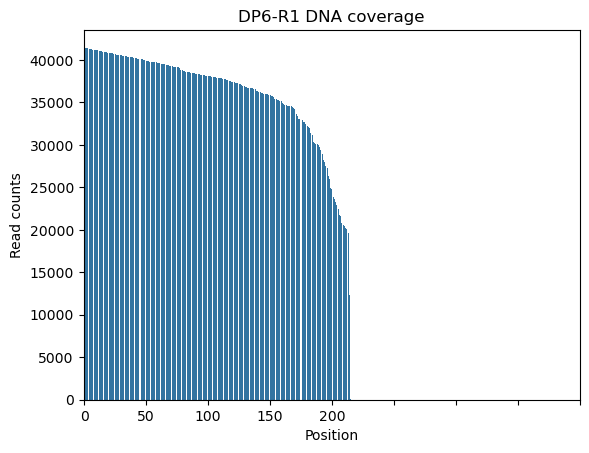

In [289]:
## plot coverage 

ax = sns.barplot(seq_variants["DNA"].sum())
plt.xticks(list(range(0,gene_len, 50)))
plt.xlabel("Position")
plt.ylabel("Read counts")
plt.title(f'{name} DNA coverage')
plt.savefig(f'{FigFolder}/{name}_DNA_coverage.pdf')
plt.show()

In [290]:
coverage = seq_variants['DNA'].sum().sum()/(seq_variants['DNA'].max().max()*seq_variants['DNA'].shape[1])*100
print(f'The illumina paired reads cover on average {coverage.round(1)} % of the LOV sequence')

mut_rate_AA = seq_variants['AA'].max()/seq_variants['AA'].sum()-1
mut_rate_AA = abs(mut_rate_AA.sum())
print(f'The mutation rate is estimated to be {mut_rate_AA.round(3)} AA mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_AA/coverage*100,3)} AA mutations per sequence')

mut_rate_DNA = seq_variants['DNA'].max()/seq_variants['DNA'].sum()-1
mut_rate_DNA = abs(mut_rate_DNA.sum())  # this is the mutation rate per nucleotide, based on the number of reads (per nt)
print(f'The mutation rate is estimated to be {mut_rate_DNA.round(3)} DNA mutations per sequence') 
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_DNA/coverage*100,3)} DNA mutations per sequence')

mut_rate_Codons = seq_variants['Codons'].max()/seq_variants['Codons'].sum()-1
mut_rate_Codons = abs(mut_rate_Codons.sum())
print(f'The mutation rate is estimated to be {mut_rate_Codons.round(3)} Codon mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_Codons/coverage*100,3)} Codon mutations per sequence')

mut_rates_dict = {"variant": name, 
                  "coverage": coverage,
                  "AA_mut_per_sequence": mut_rate_AA,
                  "AA_mut_per_sequence_coverage_corrected": mut_rate_AA/coverage*100,
                  "DNA_mut_per_sequence": mut_rate_DNA,
                  "DNA_mut_per_sequence_coverage_corrected": mut_rate_DNA/coverage*100, 
                  "Codon_mut_per_sequence": mut_rate_Codons,
                  "Codon_mut_per_sequence_coverage_corrected": mut_rate_Codons/coverage*100}

with open(f'{FigFolder}/{name}_mutation_rates.json', 'w') as file:
    file.write(json.dumps(mut_rates_dict, indent=4))

The illumina paired reads cover on average 86.6 % of the LOV sequence
The mutation rate is estimated to be 0.096 AA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.111 AA mutations per sequence
The mutation rate is estimated to be 0.145 DNA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.168 DNA mutations per sequence
The mutation rate is estimated to be 0.142 Codon mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.164 Codon mutations per sequence


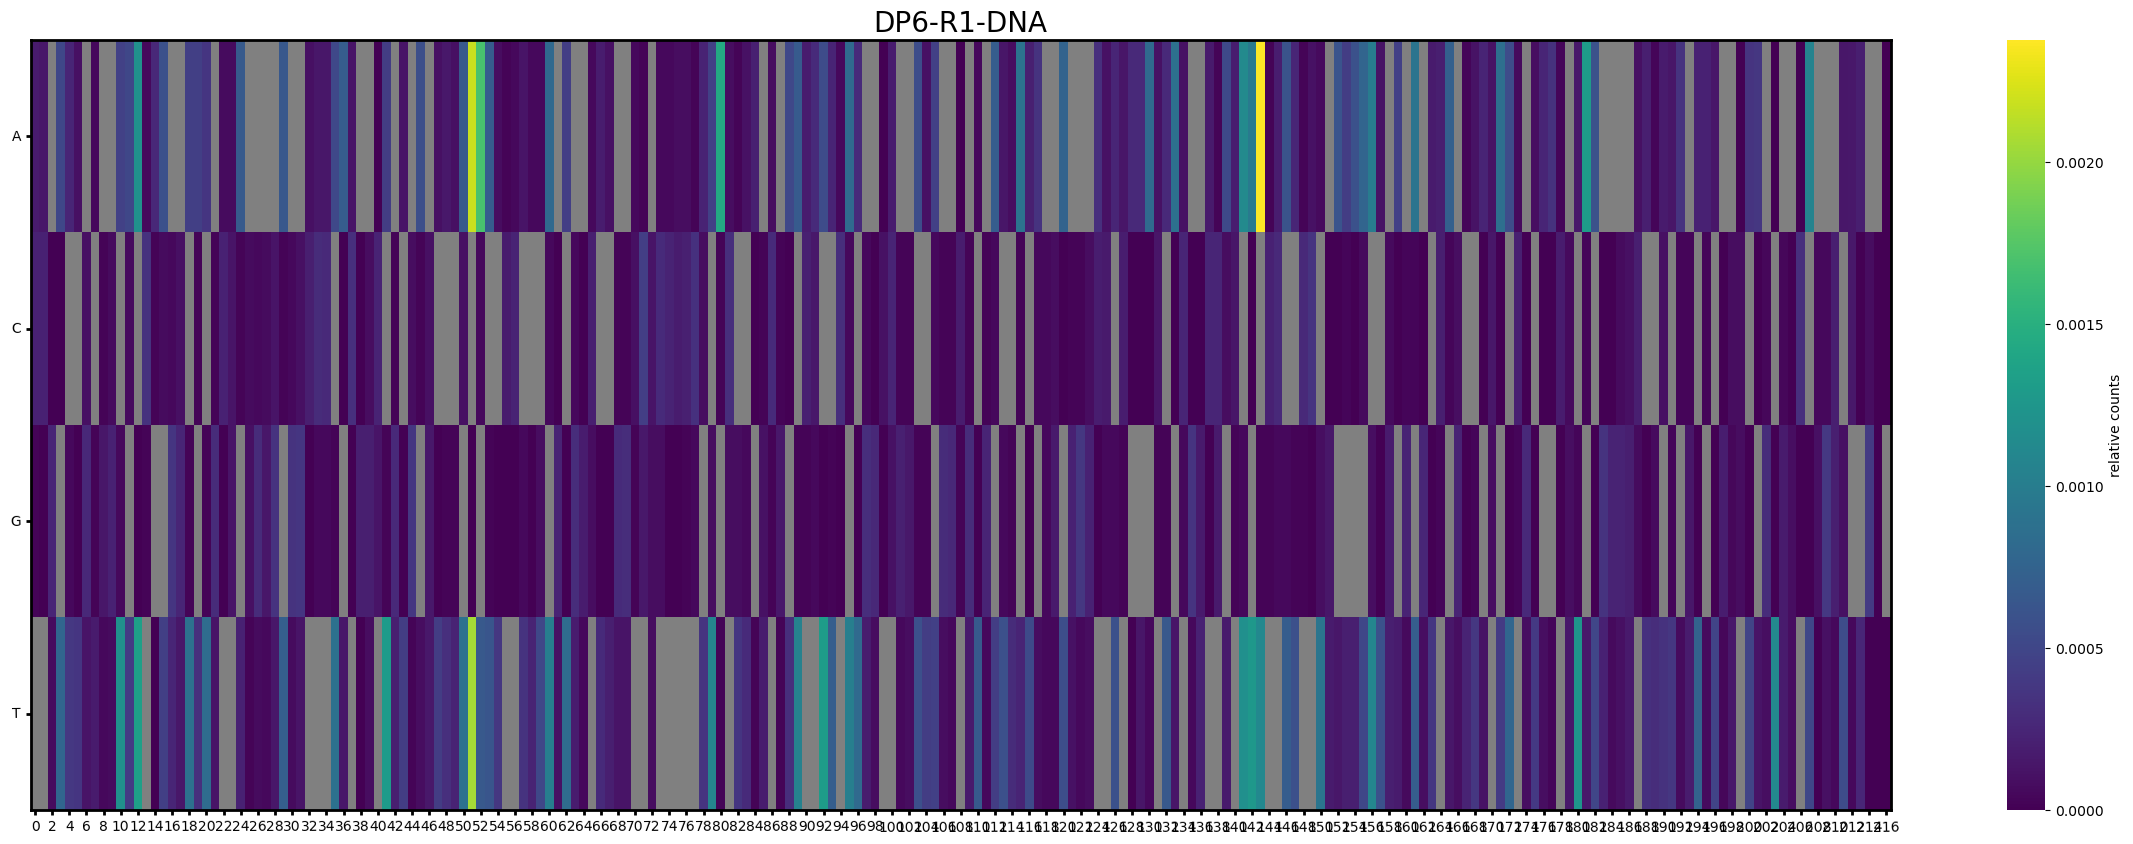

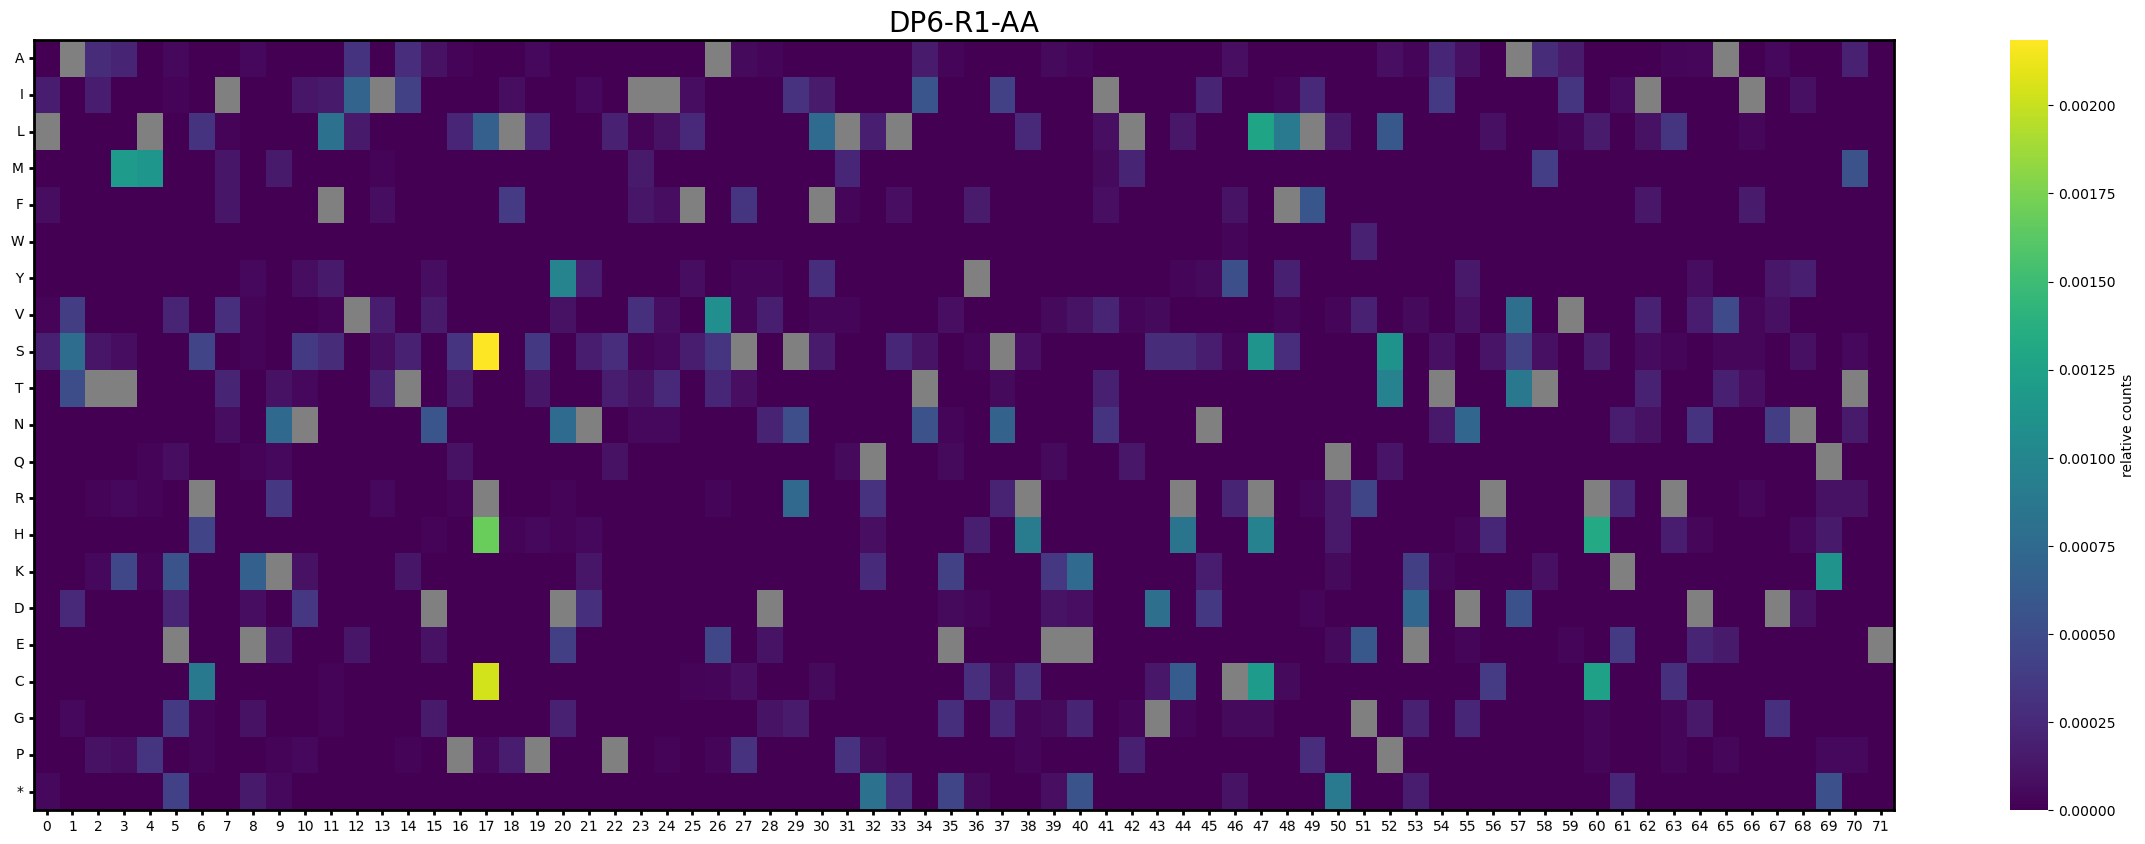

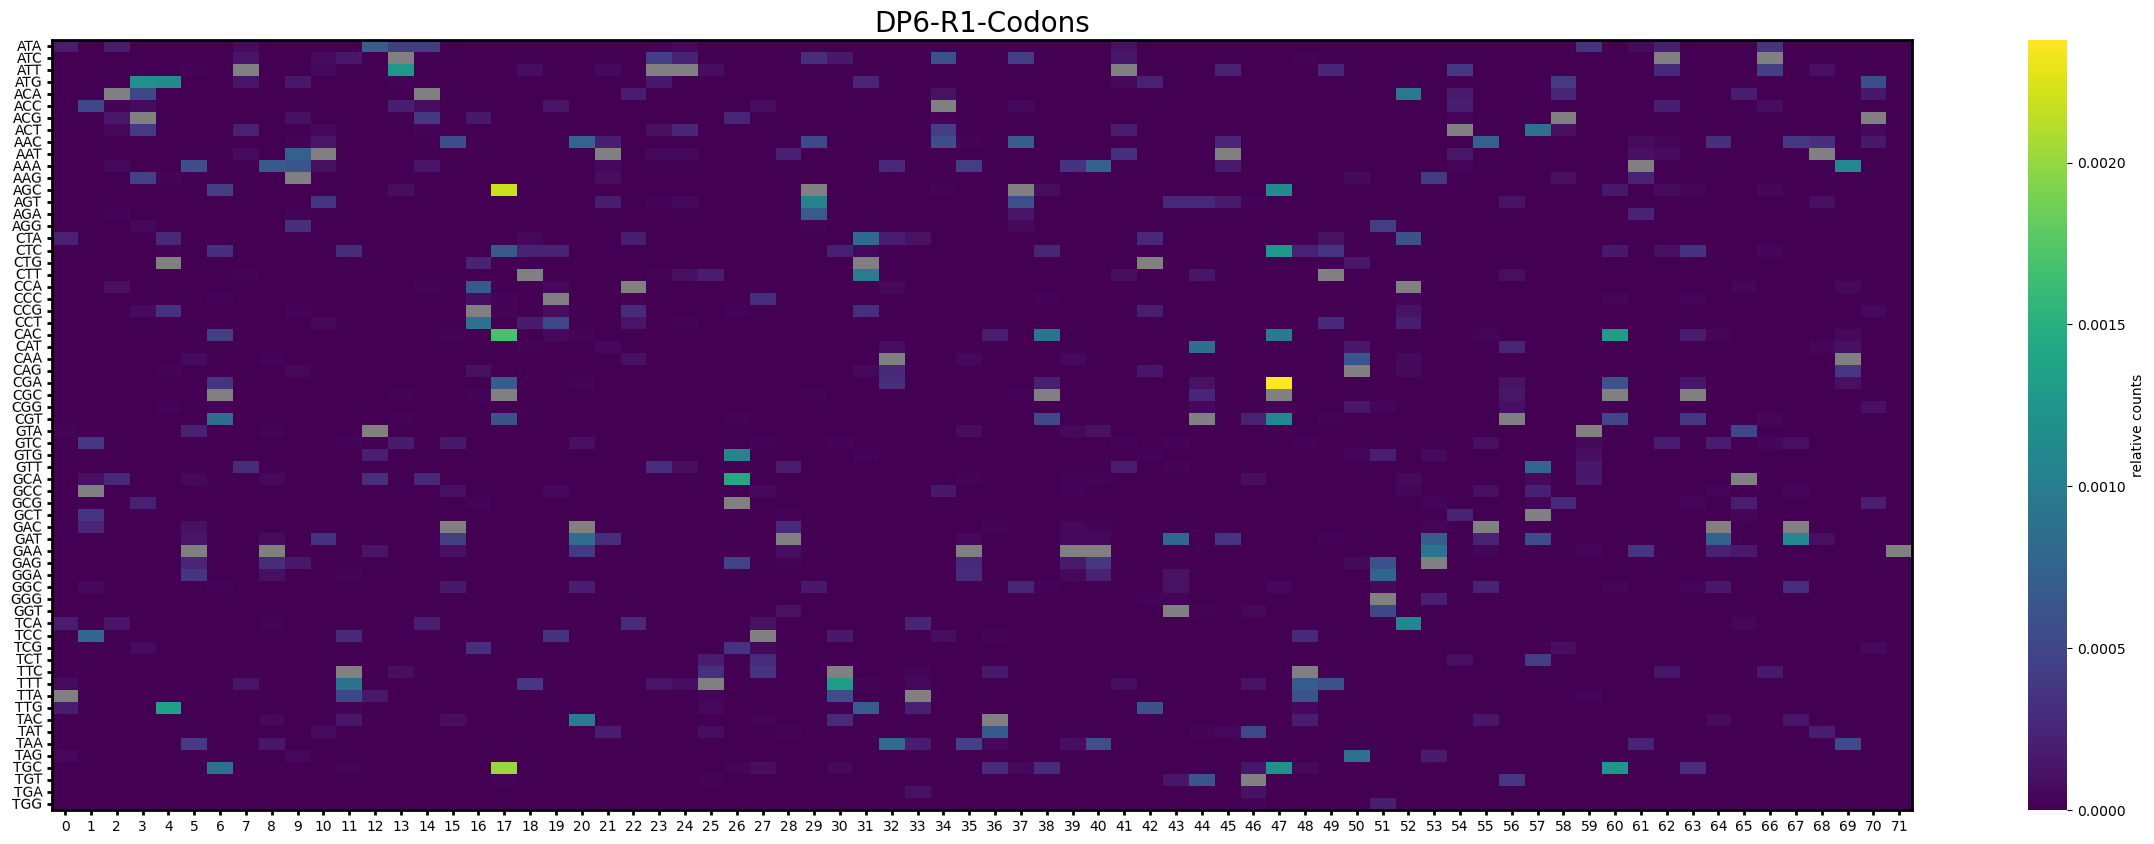

In [291]:
## plot mutation enrichment on DNA, AA and Codon level 

DNA_relative = seq_variants['DNA']/seq_variants['DNA'].sum()
DNA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(DNA_relative, name =  f'{name}-DNA', backward= not use_forward_read, data_type = "DNA", ref_seq=LOV_gene, fig_folder=FigFolder)

AA_relative = seq_variants['AA']/seq_variants['AA'].sum()
AA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(AA_relative, f'{name}-AA',ref_seq=LOV,data_type = "AA", backward = not use_forward_read, fig_folder=FigFolder)


Codons_relative = seq_variants['Codons']/seq_variants['Codons'].sum()
Codons_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(Codons_relative, f'{name}-Codons',ref_seq=LOV_gene,data_type = "Codons", backward = not use_forward_read, fig_folder=FigFolder)


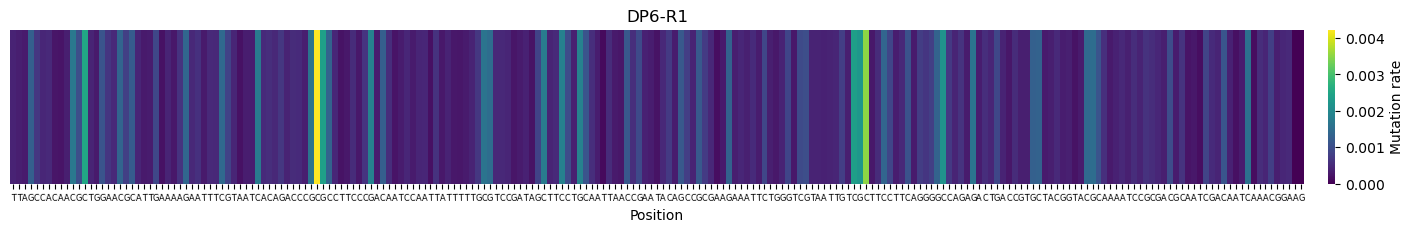

<Figure size 640x480 with 0 Axes>

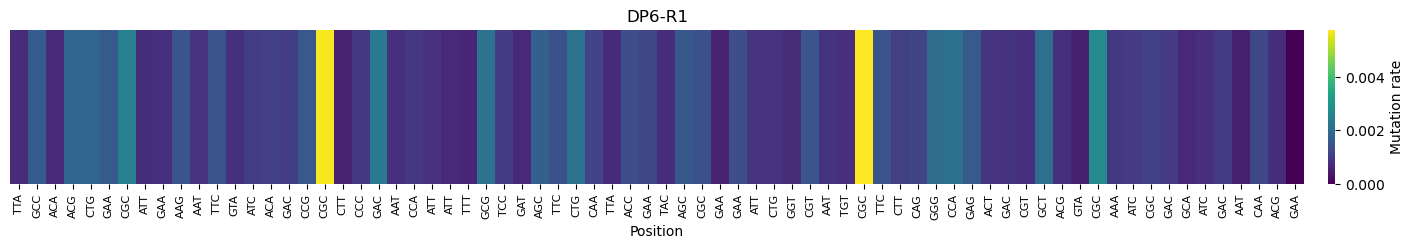

In [292]:
## plot mutation rate per position 
DNA_mut_rate_per_pos = DNA_relative.sum()-DNA_relative.max()

plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(DNA_mut_rate_per_pos).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", xticklabels=[Nt for Nt in LOV_gene[:len(DNA_mut_rate_per_pos)]], yticklabels=False)
#ax.set_xticks(ticks = list(range(len(mut_rate_per_pos))),  labels = [Nt for Nt in LOV_gene[:len(mut_rate_per_pos)]])
plt.xlabel("Position")
plt.xticks(rotation = 2,fontsize=6)
plt.title(name)
plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Nt_position.pdf", bbox_inches="tight")
plt.show()
plt.clf()

Codon_mut_rate_per_pos = Codons_relative.sum()-Codons_relative.max()
LOV_codons = [LOV_gene[i:i+3] for i in range(0, len(Codon_mut_rate_per_pos)*3, 3)]

plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(Codon_mut_rate_per_pos).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", xticklabels=LOV_codons, yticklabels=False)
plt.xlabel("Position")
plt.xticks(fontsize=8)
plt.title(name)
plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Codon_position.pdf", bbox_inches = "tight")
plt.show()
plt.clf()

In [293]:
## calculate and plot the number of Nt and Codon mutations per sequence

a_seq, b_seq = read_sequences(variant)
seq_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=False)
seq_n_Nt_mutations = dict(sorted(seq_n_Nt_mutations.items())) ## sort dictionary after key

seq_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True)
seq_n_Codon_mutations = dict(sorted(seq_n_Codon_mutations.items())) ## sort dictionary after key

print("Nt mutations", seq_n_Nt_mutations)
print("Codon mutations", seq_n_Codon_mutations)

total reads 59259
Nt mutations {0: 53464, 1: 4441, 2: 355, 3: 42, 4: 7, 5: 4, 6: 1, 7: 4, 8: 2, 9: 5, 10: 1, 11: 2, 12: 4, 13: 2, 14: 1, 15: 2, 16: 4, 17: 1, 19: 3, 20: 7, 21: 5, 22: 13, 23: 4, 24: 6, 25: 2, 26: 2, 27: 2, 28: 5, 29: 5, 30: 6, 31: 1, 32: 5, 33: 28, 34: 5, 35: 7, 36: 11, 37: 27, 38: 10, 39: 2, 40: 3, 42: 3, 43: 13, 44: 9, 45: 6, 46: 2, 47: 14, 48: 9, 49: 2, 50: 6, 51: 10, 52: 8, 53: 7, 54: 2, 55: 9, 56: 10, 57: 56, 58: 66, 59: 55, 60: 7, 61: 4, 62: 13, 63: 13, 64: 13, 65: 6, 66: 3, 67: 5, 68: 6, 69: 66, 70: 14, 71: 5, 72: 4, 73: 1, 74: 4, 75: 8, 76: 1, 78: 1, 79: 2, 80: 1, 81: 2, 82: 4, 83: 1, 84: 4, 85: 5, 86: 3, 87: 1, 88: 1, 89: 5, 90: 5, 91: 4, 92: 2, 93: 6, 94: 1, 95: 1, 96: 13, 97: 3, 98: 2, 99: 2, 100: 2, 101: 4, 102: 21, 103: 7, 104: 2, 105: 5, 106: 11, 107: 2, 108: 2, 110: 1, 111: 3, 112: 12, 113: 4, 114: 4, 115: 2, 117: 10, 118: 81, 119: 6, 123: 2, 124: 1, 126: 3, 127: 2, 129: 2, 130: 6, 131: 3, 132: 3, 133: 4, 138: 3, 139: 3, 140: 2, 141: 3, 143: 1, 146: 5, 14

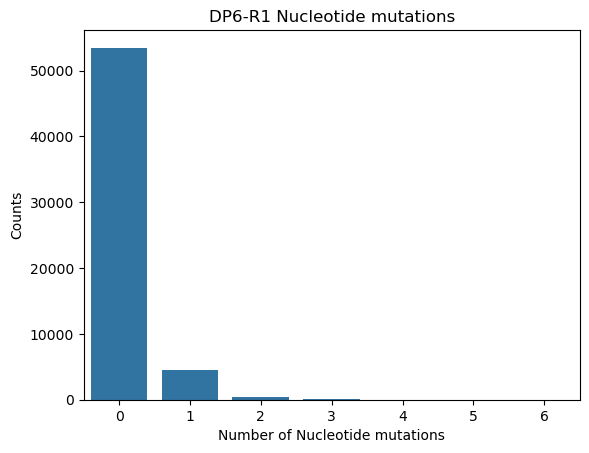

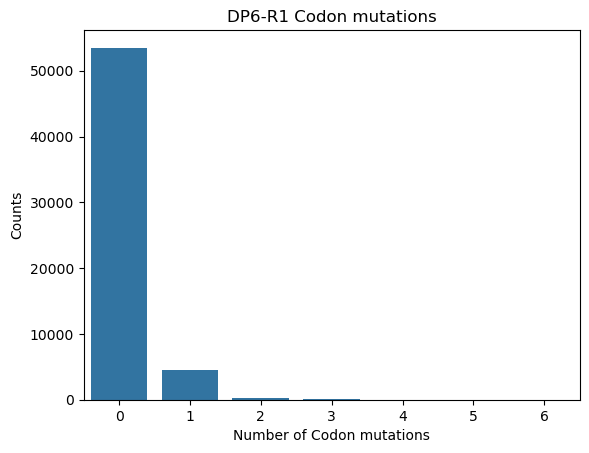

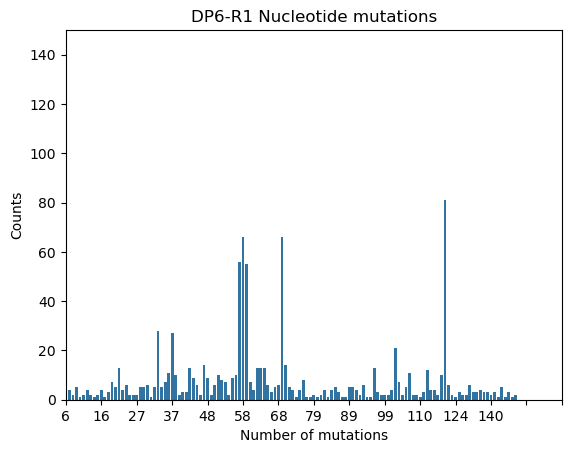

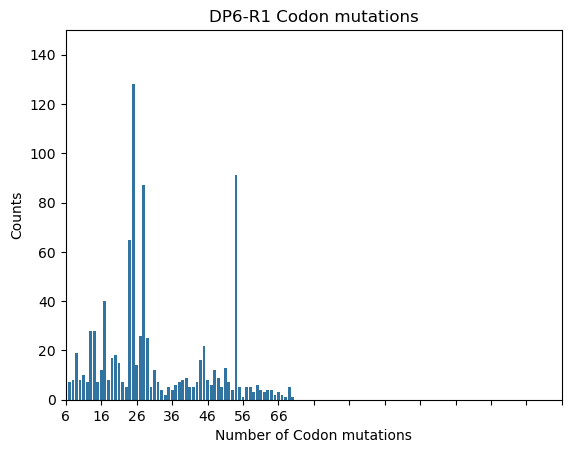

In [295]:
## plot number of Nt mutations

sns.barplot(seq_n_Nt_mutations)
plt.xlim(-0.5,6.5)
plt.xlabel('Number of Nucleotide mutations')
plt.ylabel('Counts')
plt.title(f'{name} Nucleotide mutations')
plt.savefig(f'figures/{name}_n_Nt_mutations_per_read.pdf')
plt.show()

sns.barplot(seq_n_Codon_mutations)
plt.xlim(-0.5,6.5)
plt.xlabel('Number of Codon mutations')
plt.ylabel('Counts')
plt.title(f'{variant}-R1 Codon mutations')
plt.savefig(f'figures/{name}_n_Codon_mutations_per_read.pdf')
plt.show()

plt.clf()
sns.barplot(seq_n_Nt_mutations)
plt.xlim(6.5)
plt.xticks(list(range(6, 150, 10)))
plt.ylim(0,150)
plt.xlabel('Number of mutations')
plt.ylabel('Counts')
plt.title(f'{name} Nucleotide mutations')
plt.savefig(f'figures/{name}_n_Codon_frameshift_mutations_per_read.pdf')
plt.show()
plt.clf()

sns.barplot(seq_n_Codon_mutations)
plt.xlim(6.5)
plt.xticks(list(range(6, 150, 10)))
plt.ylim(0,150)
plt.xlabel('Number of Codon mutations')
plt.ylabel('Counts')
plt.title(f'{name} Codon mutations')
plt.savefig(f'figures/{name}_n_Nt_frameshift_mutations_per_read.pdf')
plt.show()

In [ ]:
# # calculate the mutation rate (!! different to before, here, we calculate the mutation rate per read, not per nt (i.e. we divide by the number of total reads, not the reads for each nt respectively!! --> perhaps inaccurate due to low coverage of some nts)
# total_reads = sum(seq_n_mutations.values())
# total_mutations = sum([key*value for key, value in seq_n_mutations.items()])
# mutation_rate = total_mutations/total_reads
# print(mutation_rate)

In [296]:
# mutagenic spectrum

n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_forward_read=use_forward_read, treshold=7)

n_mut_spectrum_perc_df = pd.DataFrame.from_dict(n_mut_spectrum_perc, orient='index')
n_mut_spectrum_df = pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")

print(n_mut_spectrum_df)
print(n_mut_spectrum_perc_df)

np.fill_diagonal(n_mut_spectrum_perc_df.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
np.fill_diagonal(n_mut_spectrum_df.values, np.nan)


       A      C      G       T
A    0.0  103.0  506.0   226.0
C  794.0    0.0   59.0  1426.0
G  996.0   52.0    0.0   550.0
T  171.0  402.0   74.0     0.0
        A      C      G       T
A   0.000  1.922  9.442   4.217
C  14.816  0.000  1.101  26.609
G  18.586  0.970  0.000  10.263
T   3.191  7.501  1.381   0.000


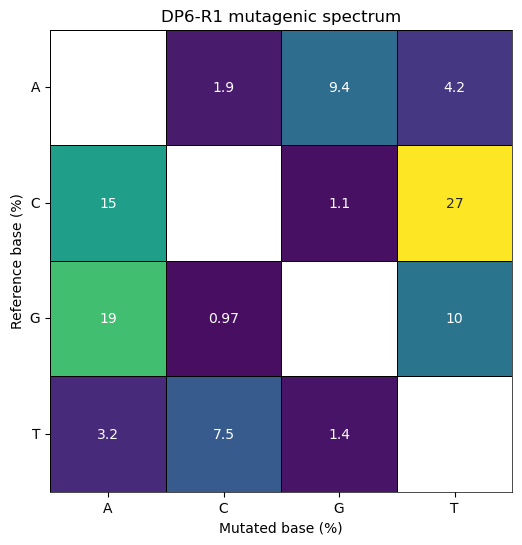

In [297]:
plot_mutation_spectrum(n_mut_spectrum_perc_df, name, fig_folder = FigFolder)

In [317]:
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read = False, use_forward_read = True, codon_list = codons, treshold = 6)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

In [318]:
mut_spectrum_codons_df = pd.DataFrame.from_dict(mut_spec_codons, orient='index')
mut_spectrum_codons_df.sum().sum()

np.int64(5207)

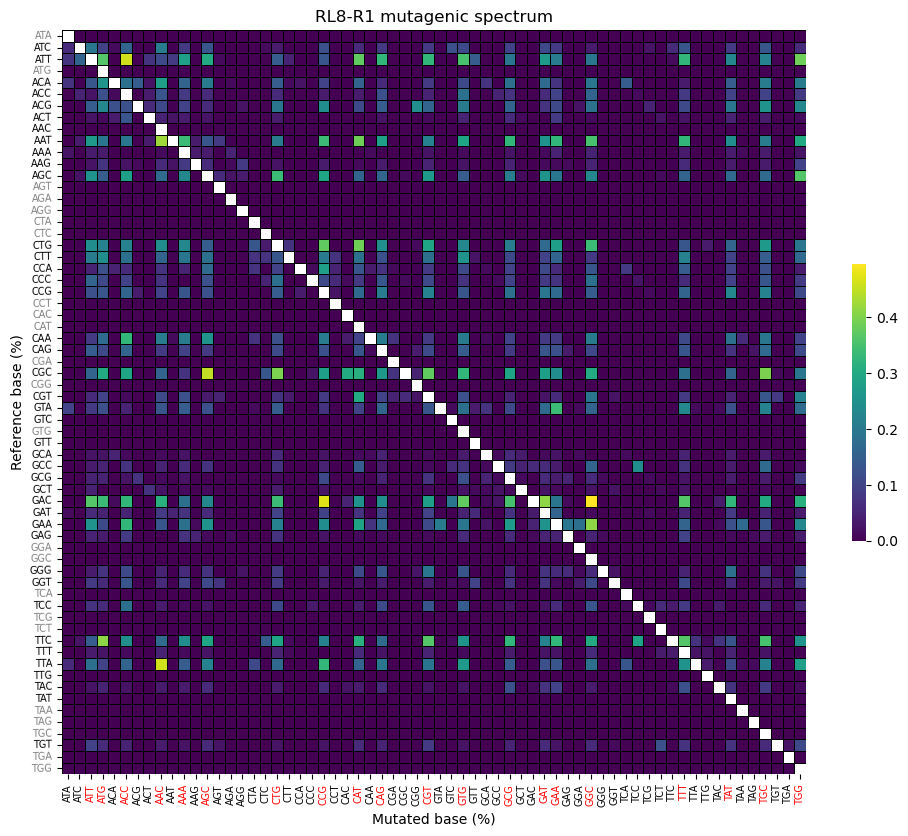

In [384]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax, vmin = 0, cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [356]:
### calculate expected mutagenic spectrum for RL8 (--> bias because of chosen Codons for AAs) (for R1 reads only)
## Codon wise
variant = "RL8"
name = "RL8-R1"
a_seq, b_seq = read_sequences(variant)
FigFolder = f"{base_dir}/figures/{name}"
max_len_R1 = max([len(seq) for seq in a_seq])
ref_seq = LOV_gene[:max_len_R1]
ref_codons = [ref_seq[i:i+3] for i in range(0, len(ref_seq)//3*3, 3)]
mut_spec_expected = {"A": {"A":0, "C":0, "G":0, "T":0}, ## {reference nt: {mutated nt: count}}
                    "C" : {"A":0, "C":0, "G":0, "T":0},
                    "G" : {"A":0, "C":0, "G":0, "T":0},
                    "T" : {"A":0, "C":0, "G":0, "T":0}}
for ref_codon in ref_codons:
    for mut_codon in ecoli_pref.values():
        ## calculate mutagenic spectrum for all expected changes per Codon
        for idx in range(3):
            if ref_codon[idx] != mut_codon[idx]:
                mut_spec_expected[ref_codon[idx]][mut_codon[idx]] += 1
        

## calculate mutagenic spectrum in percentage
total_n_muts = sum([sum(value.values()) for value in mut_spec_expected.values()])
mut_spec_expected_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec_expected.items()}
        

total reads 47233


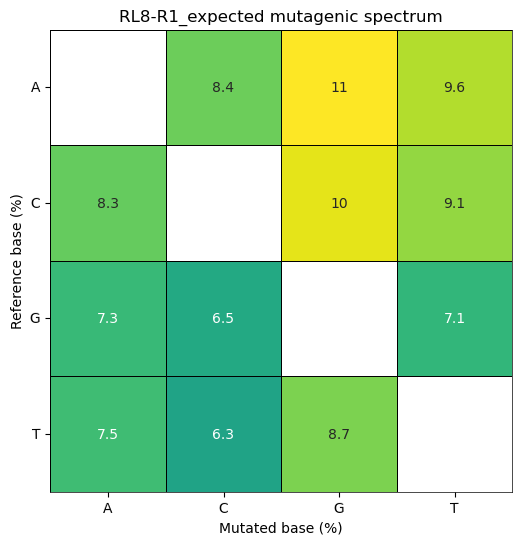

In [365]:
mut_spec_expected_perc_df = pd.DataFrame.from_dict(mut_spec_expected_perc, orient = "index")
np.fill_diagonal(mut_spec_expected_perc_df.values, np.nan)
plot_mutation_spectrum(pd.DataFrame.from_dict(mut_spec_expected_perc_df), samplename = f"{name}_expected", fig_folder = FigFolder)

In [366]:
_, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_forward_read=use_forward_read, treshold=7)

n_mut_spectrum_perc_df = pd.DataFrame.from_dict(n_mut_spectrum_perc, orient='index')


np.fill_diagonal(n_mut_spectrum_perc_df.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)

mut_spec_expected_vs_observed = mut_spec_expected_perc_df - n_mut_spectrum_perc_df

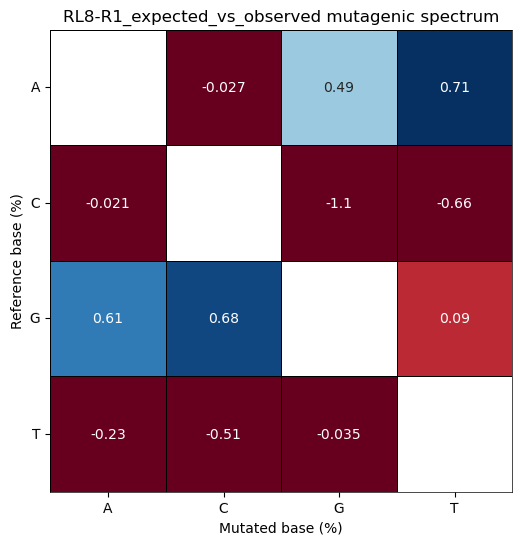

In [387]:
plot_mutation_spectrum(mut_spec_expected_vs_observed, samplename = f"{name}_expected_vs_observed", fig_folder = FigFolder, colormap = "RdBu")

In [369]:
### calculate expected Codon mutagenic spectrum for RL8 (--> bias because of chosen Codons for AAs) (for R1 reads only)

## Codon wise
variant = "RL8"
name = "RL8-R1"
a_seq, b_seq = read_sequences(variant)
FigFolder = f"{base_dir}/figures/{name}"
max_len_R1 = max([len(seq) for seq in a_seq])
ref_seq = LOV_gene[:max_len_R1]
ref_codons = [ref_seq[i:i+3] for i in range(0, len(ref_seq)//3*3, 3)]
codon_list = codons

Codon_mut_spec_expected = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list} # reference_codon : {mutated_codon: count}

for ref_codon in ref_codons:
    for mut_codon in ecoli_pref.values():
        ## calculate mutagenic spectrum for all expected codons per codon
            if ref_codon != mut_codon:
                Codon_mut_spec_expected[ref_codon][mut_codon] += 1
        

## calculate mutagenic spectrum in percentage
total_n_muts = sum([sum(value.values()) for value in Codon_mut_spec_expected.values()])
Codon_mut_spec_expected_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in Codon_mut_spec_expected.items()}



total reads 47233


In [370]:
Codon_mut_spec_expected_perc_df = pd.DataFrame.from_dict(Codon_mut_spec_expected_perc, orient = "index")
np.fill_diagonal(Codon_mut_spec_expected_perc_df.values, np.nan)

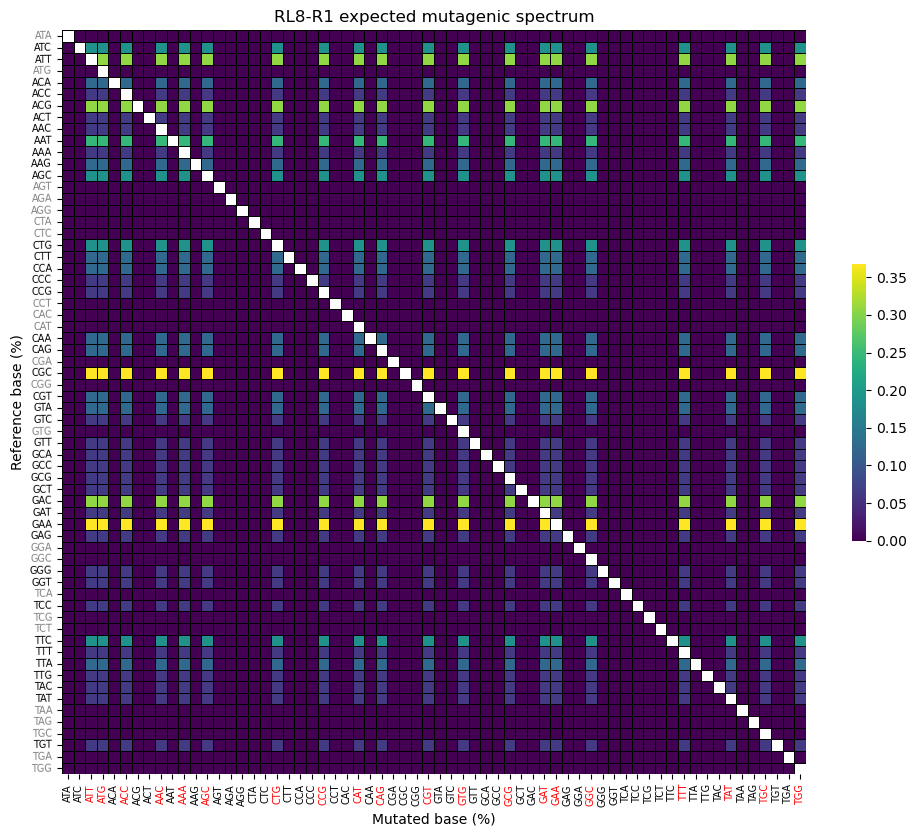

In [385]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(Codon_mut_spec_expected_perc_df, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} expected mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_expected_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [374]:
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read = False, use_forward_read = True, codon_list = codons, treshold = 6)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

mut_spectrum_codons_expected_vs_observed = Codon_mut_spec_expected_perc_df - mut_spectrum_codons_perc_df

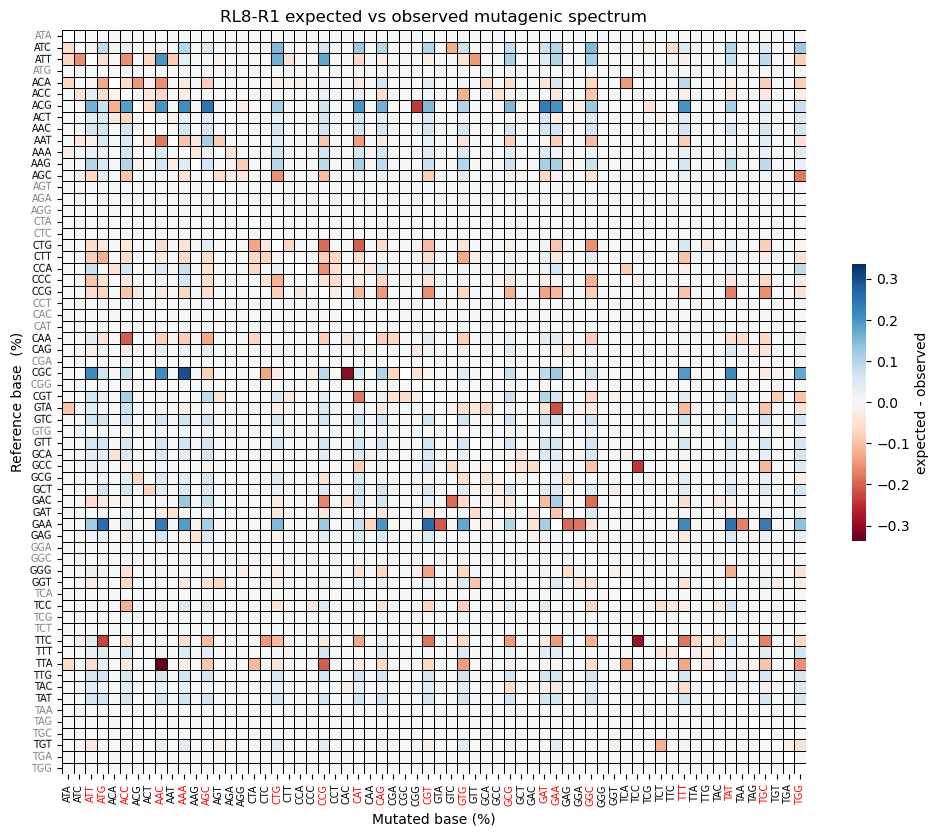

In [403]:
f, ax = plt.subplots(figsize=(12, 12))
cmap_max = np.max(abs(mut_spectrum_codons_expected_vs_observed))
sns.heatmap(mut_spectrum_codons_expected_vs_observed, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "RdBu",vmin = -cmap_max, vmax = cmap_max ,cbar_kws={'shrink': 0.3, "label" : "expected - observed"},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base  (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')


for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} expected vs observed mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_expected_vs_observed_mutagenic_spectrum_codons_perc.pdf")
plt.show()

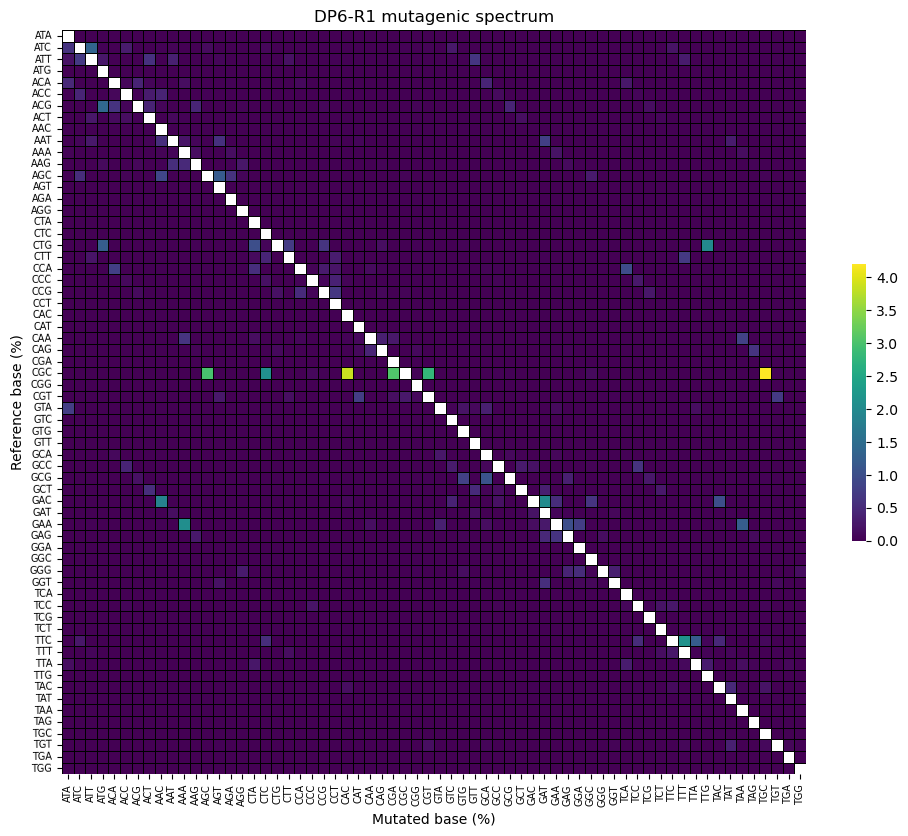

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax, vmin = 0, cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

# for i, tick_label in enumerate(ax.get_xticklabels()):
#     if tick_label.get_text() in ecoli_pref.values():
#         tick_label.set_color('red')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc.pdf")
plt.show()

## Compare RL8 and DP6

In [322]:
## calculate and plot the number of Nt and Codon mutations per sequence

a_seq, b_seq = read_sequences("DP6")
DP6_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=False)
DP6_n_Nt_mutations = dict(sorted(DP6_n_Nt_mutations.items())) ## sort dictionary after key

DP6_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True)
DP6_n_Codon_mutations = dict(sorted(DP6_n_Codon_mutations.items())) ## sort dictionary after key


a_seq, b_seq = read_sequences("RL8")
RL8_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=False)
RL8_n_Nt_mutations = dict(sorted(RL8_n_Nt_mutations.items())) ## sort dictionary after key

RL8_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True)
RL8_n_Codon_mutations = dict(sorted(RL8_n_Codon_mutations.items())) ## sort dictionary after key


total reads 59259
total reads 47233


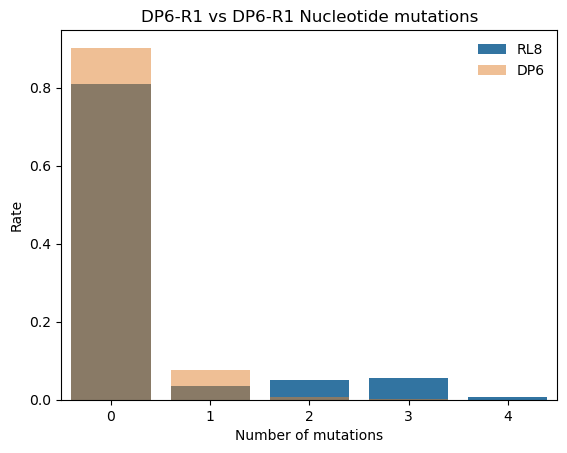

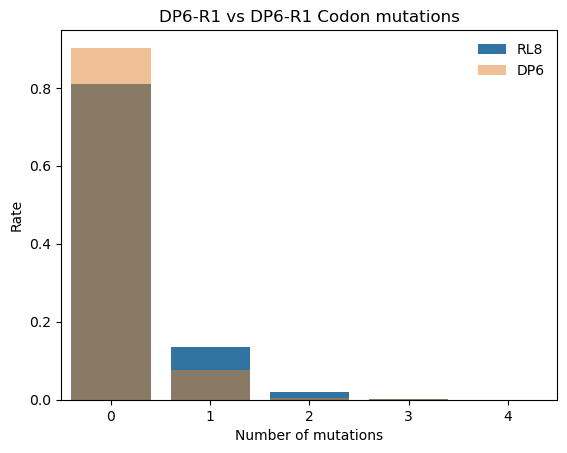

In [324]:
# rates of single, double, triple, ... mutations
total_reads = sum(DP6_n_Nt_mutations.values())
DP6_n_Nt_mutation_rates = {key: value/total_reads for key, value in DP6_n_Nt_mutations.items()}

total_reads = sum(DP6_n_Codon_mutations.values())
DP6_n_Codon_mutation_rates = {key: value/total_reads for key, value in DP6_n_Codon_mutations.items()}


total_reads = sum(RL8_n_Nt_mutations.values())
RL8_n_Nt_mutation_rates = {key: value/total_reads for key, value in RL8_n_Nt_mutations.items()}

total_reads = sum(RL8_n_Codon_mutations.values())
RL8_n_Codon_mutation_rates = {key: value/total_reads for key, value in RL8_n_Codon_mutations.items()}

sns.barplot(RL8_n_Nt_mutation_rates, label = "RL8")
sns.barplot(DP6_n_Nt_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Nucleotide mutations') 
plt.savefig(f'figures/RL8-R1_vs_DP6-R1_n_Nt_mutation_per_read_rates.pdf')
plt.show()
plt.clf()

sns.barplot(RL8_n_Codon_mutation_rates, label = "RL8")
sns.barplot(DP6_n_Codon_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Codon mutations') 
plt.savefig(f'figures/RL8-R1_vs_DP6-R1_n_Codon_mutation_per_read_rates.pdf')
plt.show()

### Impact of read depth on mutation rate?

In [133]:
### randomly sample down the reads --> impact on mutation rate?
variant = "DP6"
name = "DP6-R1"
FigFolder = f"{base_dir}/figures/impact_of_read_depth/{name}"

a_seq, b_seq = read_sequences(variant)
percs = [0.05, 0.01] + [x * 0.1 for x in range(1, 11)]

coverages_dict, mut_rates_AA_dict, mut_rates_DNA_dict =  mutation_rate_vs_read_depth(a_seq=a_seq, b_seq=b_seq, percs = percs, n_perms = 30, fig_folder = FigFolder, name = name, use_backward_read=False)


total reads 59259
86.67365307492696
86.56177783405616
86.86314689810351
86.74561737459436
87.25177021775009


KeyboardInterrupt: 

In [653]:
mut_spec_diff_mse, _= calc_mut_spectrum_vs_read_depth(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_forward_read=True, prop = 0.3, n_perms = 30)

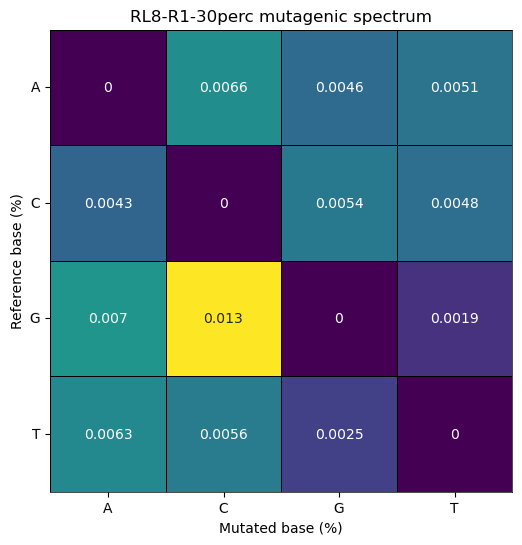

In [654]:
plot_mutation_spectrum(mut_spec_diff_mse, f"{variant}-R1-30perc", fig_folder =FigFolder)

In [657]:
percs = [0.05, 0.01] + [x * 0.1 for x in range(1, 11)]
mean_diffs_dict = {}

for  perc in percs: 
    _, mean_diffs= calc_mut_spectrum_vs_read_depth(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_forward_read=True, prop = perc, n_perms = 50)
    mean_diffs_dict[round(perc, 2)] = mean_diffs


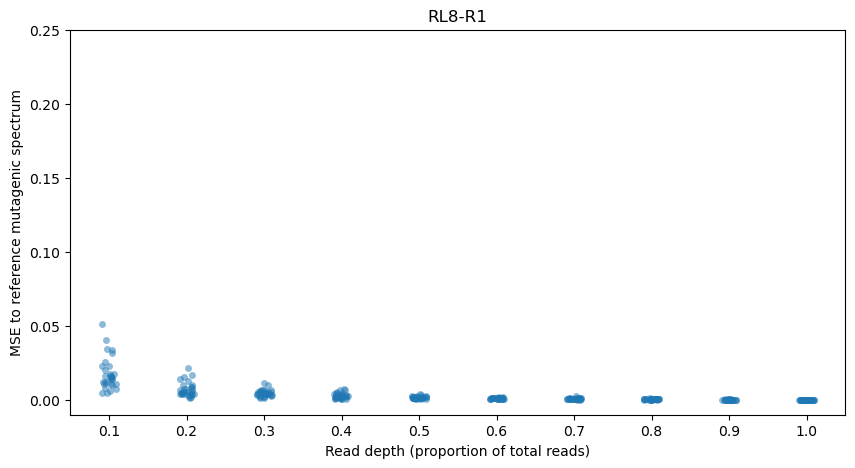

In [656]:
plt.figure(figsize=(10,5))
sns.stripplot(data=mean_diffs_dict,  alpha=0.5, color="tab:blue")
plt.ylim(-0.01, 0.25)
plt.xlim(1.5)
plt.xlabel("Read depth (proportion of total reads)")
plt.ylabel("MSE to reference mutagenic spectrum")
plt.title(name)
plt.savefig(f"{FigFolder}/{name}_mutation_rate_vs_read_depth_from10perc.pdf")
plt.show()

In [241]:
## how many A, C, G, T are in the reference sequence
for nt in set(LOV_gene): 
    print(nt, LOV_gene[-20:].count(nt))


T 3
C 4
G 6
A 7


In [89]:
a_seq, b_seq = read_sequences("DP6")
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read = False, use_forward_read = True, codon_list = codons, treshold = 5)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

total reads 59259


In [90]:
mut_spectrum_codons_df = pd.DataFrame.from_dict(mut_spec_codons, orient='index')
mut_spectrum_codons_df.sum().sum()

np.int64(5204)

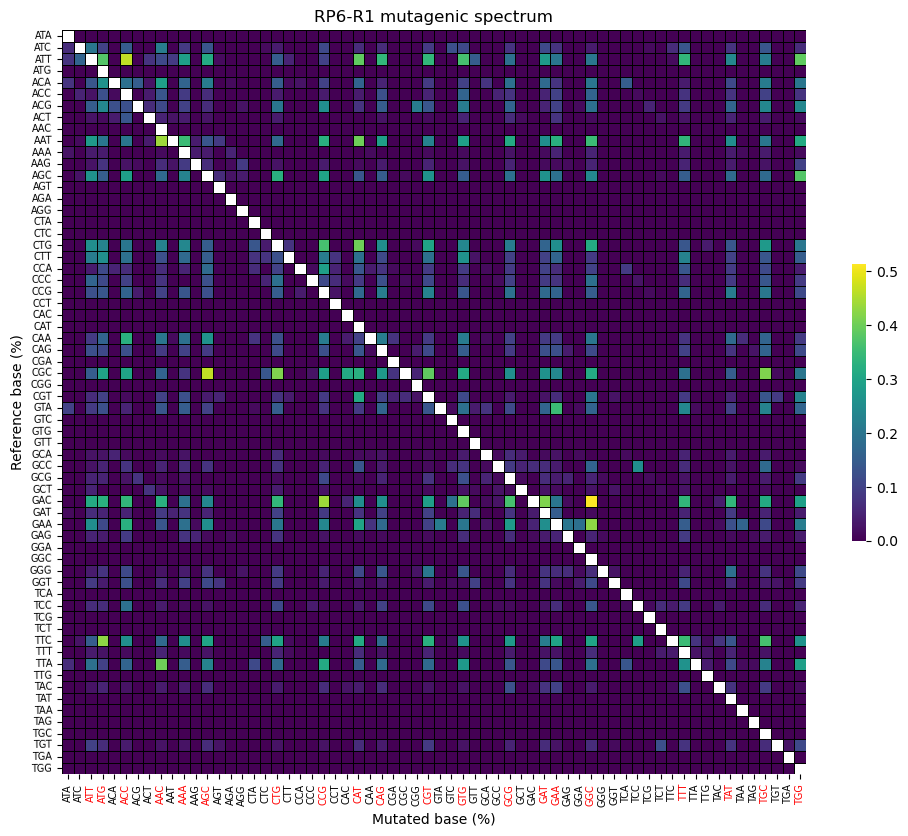

In [127]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax, vmin = 0, cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
       tick_label.set_color('red')
# for i, tick_label in enumerate(ax.get_yticklabels()):
#     if tick_label.get_text() not in ecoli_pref.values():
#         tick_label.set_color('green')
plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.show()